In [99]:
import os
from datetime import datetime
import json
from pydicom import dcmread
from pydicom.data import get_testdata_file
import matplotlib.pyplot as plt
import numpy as np
import cv2
def extractingIdDCM(ds2):
    id=ds2.SOPInstanceUID
    return id
def extractingPatientIdDCM(ds2):
    patient_id=ds2.PatientID
    return patient_id
def extractingManufacturer(ds2):
    manufacturer=ds2.Manufacturer
    return manufacturer
def extractingType(ds2):
    try:
        type=ds2.SequenceOfUltrasoundRegions[1].RegionDataType
        return type 
    except:
        return 0
def extractingEchoImg(ds2,coordenadasEcho):
    if(len(ds2.SequenceOfUltrasoundRegions)==2):
        Y0=ds2.SequenceOfUltrasoundRegions[0].RegionLocationMinY0
        Y1=ds2.SequenceOfUltrasoundRegions[0].RegionLocationMaxY1
        X0=ds2.SequenceOfUltrasoundRegions[0].RegionLocationMinX0
        X1=ds2.SequenceOfUltrasoundRegions[0].RegionLocationMaxX1
        img2D=ds2.pixel_array[Y0:Y1,X0:X1,:]
        img2D=convert_ybr_to_rgb(img2D)

        Y0=ds2.SequenceOfUltrasoundRegions[1].RegionLocationMinY0
        Y1=ds2.SequenceOfUltrasoundRegions[1].RegionLocationMaxY1
        X0=ds2.SequenceOfUltrasoundRegions[1].RegionLocationMinX0
        X1=ds2.SequenceOfUltrasoundRegions[1].RegionLocationMaxX1
        Echo=ds2.pixel_array[Y0:Y1,X0:X1,:]
        Echo=convert_ybr_to_rgb(Echo)
    else:
        Y0=ds2.SequenceOfUltrasoundRegions[0].RegionLocationMinY0
        Y1=ds2.SequenceOfUltrasoundRegions[0].RegionLocationMaxY1
        X0=ds2.SequenceOfUltrasoundRegions[0].RegionLocationMinX0
        X1=ds2.SequenceOfUltrasoundRegions[0].RegionLocationMaxX1
        Echo=ds2.pixel_array[Y0:Y1,X0:X1,:]
        img2D=np.array([])
        Echo=convert_ybr_to_rgb(Echo)
        
    return (Echo,img2D)
def curvePointsExtraction(curvePoints):
    xi=0;yi=0;yf=0;xf=0
    for i in range(len(curvePoints)):
        if (curvePoints[i].get('type')=='cycle beginning'):
            xi=curvePoints[i].get('x')
            yi=curvePoints[i].get('y')
            
        elif(curvePoints[i].get('type')=='cycle end'):
            xf=curvePoints[i].get('x')
            yf=curvePoints[i].get('y')
    
    return xi,yi,xf,yf
def convert_ybr_to_rgb(arr):
    if len(arr.shape) == 4:
        return np.vstack([convert_ybr_to_rgb(a)[np.newaxis] for a in arr])
    else:
        temp = arr[..., 1].copy()
        arr[..., 1] = arr[..., 2]
        arr[..., 2] = temp
        return cv2.cvtColor(arr, cv2.COLOR_YCR_CB2RGB)

In [2]:

dirDicom ='/mnt/d/USER/Drive UPF/TFM/Datasets/export_minio/export_minio/'
#files=os.walk(dir,topdown=True)
dicomfiles=[]
dicom_id=[]
total = 0
num_archivos = 0
formato = '%d-%m-%y %H:%M:%S'
linea = '-' * 60
for ruta, directorios, archivos in os.walk(dirDicom, topdown=True):
    #print('\nruta       :', ruta) 
    for elemento in archivos:
        num_archivos += 1
        archivo = ruta + os.sep + elemento
        estado = os.stat(archivo)
        tamaño = estado.st_size
        dicomfiles.append(elemento)
        if(elemento!='desktop.ini'):

            ds2 = dcmread(archivo)
            dicom_id.append(extractingIdDCM(ds2))
            #print(archivo)


print('Núm. archivos:', num_archivos)
len(dicomfiles)

Núm. archivos: 7286


7286

In [3]:
import json
jsonfiles=[]
dirJSON='/mnt/d/USER/Drive UPF/TFM/Datasets/export_mongo/export_mongo/'
num_archivos = 0
for ruta, directorios, archivos in os.walk(dirJSON, topdown=True):
    #print('\nruta       :', ruta) 
        for elemento in archivos:
            
            if(elemento!='desktop.ini'):
                jsonfiles.append(ruta+'/'+elemento)
                num_archivos += 1 

print('Núm. archivos:', num_archivos)


Núm. archivos: 430


In [4]:
idEval=[];

for i in jsonfiles:
    #path=jsonfiles

    with open(i) as myfile:
        data = json.load(myfile)
        
    analysisData=data.get('analysis')[0]
    imagesAnalysis=analysisData.get('images')
    
    for j in range(0,len(imagesAnalysis)):
        Id=imagesAnalysis[j].get('id')
        idEval.append(Id)
        
len(idEval)

6442

In [5]:
import pandas as pd
idEval2=pd.unique(idEval)

In [6]:
examsVal=[]

for i in range(0,len(idEval2)):
    for j in range(0,len(dicom_id)):
        if (idEval2[i]==dicom_id[j]):
            examsVal.append(idEval2[i])
            break;
        
len(examsVal)

2755

In [7]:
clases=[]
rutasjson=[]
coordenadas=[]
for i in jsonfiles:
    #path=jsonfiles
    
    with open(i) as myfile:
        data = json.load(myfile)

    analysisData=data.get('analysis')[0]
    imagesAnalysis=analysisData.get('images')
    
    for k in examsVal:
        for j in range(0,len(imagesAnalysis)):
            Id=imagesAnalysis[j].get('id')
            if(Id==k):
                clases.append(imagesAnalysis[j].get('type'))
                rutasjson.append(i)
                curvePoints=imagesAnalysis[j].get('curve').get('control_points')
                xi,yi,xf,yf=curvePointsExtraction(curvePoints)
                coord=[xi,xf]
                coordenadas.append(coord)
                break;

In [8]:
len(coordenadas)

2755

In [8]:
echoImgs=[]
bdImgs=[]
rutas=[]
ids=[]
classes=[]
names=[]
patients=[]
idpatients=[]
sourcedb=[];typeDoppler=[];
aduheart=0;covid=0;clinic=0;kids=0;
for ruta, directorios, archivos in os.walk(dirDicom, topdown=True):
    #print('\nruta       :', ruta) 
    for elemento in archivos:
        archivo = ruta + os.sep + elemento
        
        if(elemento!='desktop.ini'):
            ds2 = dcmread(archivo)
            id=extractingIdDCM(ds2)
            for i in range(0,len(examsVal)):
                if(id==examsVal[i]):
                        #print(i,id,archivo)
                        #ds2 = dcmread(archivo)
                    echoImg,bdImg=extractingEchoImg(ds2,coordenadas[i])
                    if(bdImg.size>0):
                        echoImgs.append(echoImg)
                        bdImgs.append(bdImg)
                        rutas.append(archivo)
                        ids.append(id)
                        classes.append(clases[i])
                        names.append(elemento)
                        patientid=ds2.PatientID
                        a=ruta.split('/')
                        dbname=a[9]
                        sourcedb.append(dbname)
                        typeDoppler.append(extractingType(ds2))
                        break;
      

In [36]:
CW=0;PW=0;none=0;
for i in range(0,len(typeDoppler)):
    if typeDoppler[i]==3:
        PW=PW+1;
    elif typeDoppler[i]==4:
        CW=CW+1;
        
    elif typeDoppler[i]==0:
        none=none+1;
        
print(PW, CW, none) #no hay TVD segun los DICOM

2265 264 1


In [29]:
dbs={}
for patient in patients:
    a=patient[0].split('/')
    dbname=a[9]
    if dbname not in dbs:
        dbs[dbname]=[]
    dbs[dbname].append([patient[1],patient[2]])
    

In [75]:
len(dbs['dcmsickkids'])

91

124 125 3


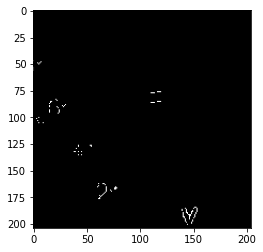

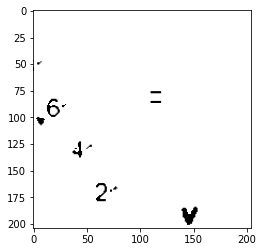

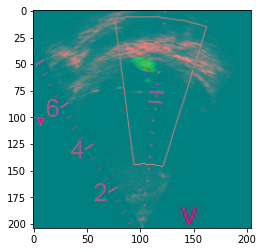

In [97]:
from skimage import morphology, filters
import sklearn.preprocessing as sk

#th=filters.threshold_otsu(bdImgs[5][:,:,1])
#img=cv2.medianBlur(bdImgs[5],3)
#img = cv2.GaussianBlur(bdImgs[5],(5,5),0)
num=1000
img=cv2.bilateralFilter(bdImgs[num],20,75,75)
img= sk.binarize(img[:,:,1], threshold=105)#hasta aquí puedo mantener lo que no es marcador y extraerlo de la imagen final

#img= sk.binarize(bdImgs[5][:,:,1], threshold=105)
img2=cv2.medianBlur(bdImgs[num],3)
#img2=cv2.bilateralFilter(bdImgs[5],10,75,75)
img2= sk.binarize(img2[:,:,1], threshold=105)
newimg=img2-img
plt.figure()
plt.imshow(newimg, cmap=plt.cm.gray)

plt.figure()
plt.imshow(img2, cmap=plt.cm.gray)
plt.figure()
plt.imshow(bdImgs[num],cmap=plt.cm.gray)
x,y,z=bdImgs[1].shape
print(x,y,z)

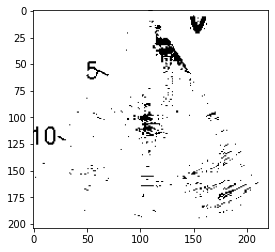

In [47]:
th=filters.threshold_otsu(bdImgs[145][:,:,1])
img= sk.binarize(bdImgs[1285][:,:,1], threshold=105)
plt.figure()
plt.imshow(img, cmap=plt.cm.gray)

In [ ]:
sizesEcho=[]
sizes2D=[]
for i in range(0,len(echoImgs)):
    sizeEchos=echoImgs[i].shape
    size2d=bdImgs[i].shape
    if(sizeEchos not in sizesEcho):
        sizesEcho.append(sizeEchos)
    if(size2d not in sizes2D):
        sizes2D.append(size2d)
        

In [10]:
classifications=[]
for i in range(0,len(classes)):
    label=classes[i]
    if label not in classifications:
        classifications.append(label)

In [11]:
classifications

['Pulmonary Artery',
 'PW TDI Lateral Tricuspid',
 'Mitral valve PW Doppler',
 'PW TDI Lateral Mitral',
 'PW TDI Septal Mitral',
 'Pulmonary vein',
 'Aortic valve',
 'Tricuspid valve PW Doppler',
 'Mitral valve CW Doppler',
 'Tricuspid valve CW Doppler']

In [13]:
DATABASE=[];
for i in range(len(bdImgs)):
    a={'echoImg': echoImgs[i], 'bdImg': bdImgs[i], 'id': ids[i], 'class': classes[i], 'filename': names[i], 'path': rutas[i]}
    DATABASE.append(a)
DATABASE=np.array(DATABASE)


In [46]:
DBImgs=[];
label=[];bbdd=[]
for i in range(len(bdImgs)):
    if(bdImgs[i].size>0):
        a={'echoImg': echoImgs[i], 'bdImg': bdImgs[i],'class': classes[i],'source': sourcedb[i],'filename': names[i]}
        label.append(classes[i])
        bbdd.append(sourcedb[i])
        DBImgs.append(a)

In [31]:
from sklearn.preprocessing import LabelEncoder 
#to convert the categorical labels as integers
le = LabelEncoder()
labelN=le.fit_transform(label)
bbddN=le.fit_transform(bbdd)

In [39]:
from cantor import pair,depair
#X_train, X_test, y_train, y_test = train_test_split(DATABASE, label, test_size=0.3,random_state=42)
label_stratified = pair(labelN, bbddN)
label_stratified = 100000*labelN + bbddN
X_train, X_test,  y_train_paired, y_test_paired  = train_test_split(DBImgs, label_stratified, test_size=1/4,random_state=42, stratify=label_stratified)
y_train = depair(y_train_paired)
y_test  = depair(y_test_paired)


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=1/3, random_state=42, stratify=y_train)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(DBImgs, label, test_size=0.3,random_state=42, stratify=label)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=1/3,random_state=42, stratify=y_train)

In [49]:
from PIL import Image
k=0;
for i in range(len(X_train)):
    for j in classifications:
        if y_train[i]==j:
            if(X_train[i]['bdImg'].size>0):
                imDoppler=Image.fromarray(X_train[i]['echoImg']);
                imBD=Image.fromarray(X_train[i]['bdImg']);
                imBD.save('/mnt/d/USER/Drive UPF/TFM/Datasets/Resnet18/NewDatasetNAMES/BD/train/'+y_train[i]+'/'+X_train[i]['filename']+".png")
                imDoppler.save('/mnt/d/USER/Drive UPF/TFM/Datasets/Resnet18/NewDatasetNAMES/Doppler/train/'+y_train[i]+'/'+X_train[i]['filename']+".png")
                k=k+1;
                break;
print(k)

1180


In [50]:

k=0;
for i in range(len(X_test)):
    for j in classifications:
        if y_test[i]==j:
            if(X_test[i]['bdImg'].size>0):
                imDoppler=Image.fromarray(X_test[i]['echoImg']);
                imBD=Image.fromarray(X_test[i]['bdImg']);
                imBD.save('/mnt/d/USER/Drive UPF/TFM/Datasets/Resnet18/NewDatasetNAMES/BD/test/'+y_test[i]+'/'+X_test[i]['filename']+".png")
                imDoppler.save('/mnt/d/USER/Drive UPF/TFM/Datasets/Resnet18/NewDatasetNAMES/Doppler/test/'+y_test[i]+'/'+X_test[i]['filename']+".png")
                k=k+1;
                break;
print(k)

759


In [51]:

k=0;
for i in range(len(X_valid)):
    for j in classifications:
        if y_valid[i]==j:
            if(X_valid[i]['bdImg'].size>0):
                imDoppler=Image.fromarray(X_valid[i]['echoImg']);
                imBD=Image.fromarray(X_valid[i]['bdImg']);
                imBD.save('/mnt/d/USER/Drive UPF/TFM/Datasets/Resnet18/NewDatasetNAMES/BD/val/'+y_valid[i]+'/'+X_valid[i]['filename']+".png")
                imDoppler.save('/mnt/d/USER/Drive UPF/TFM/Datasets/Resnet18/NewDatasetNAMES/Doppler/val/'+y_valid[i]+'/'+X_valid[i]['filename']+".png")
                k=k+1;
                break;
print(k)

591


In [13]:
np.save('EchoDB_act.npy',DBImgs,allow_pickle=True)